In [2]:
import gurobipy as gp
from gurobipy import Model, GRB

In [3]:
def run_optimization():
    # Get user input for demand and facility parameters
    demand = int(input("Enter the demand (tonnes per day): "))
    min_facilities = int(input("Enter the minimum number of facilities: "))
    max_facilities = int(input("Enter the maximum number of facilities: "))
    production_capacity_per_facility = float(input("Enter the production capacity per facility (tonnes per day): "))

    # Facility costs (in crore ₹)
    capital_cost_production = 354.825  # per facility (converted from $47.31M to crore ₹)
    capital_cost_storage = 0.6        # per tonne (converted from $0.08M to crore ₹)
    capital_cost_transport = 0.0075   # per tonne-km (converted from $0.001M to crore ₹)
    facility_setup_cost = 2000        # cost to set up one facility in crore ₹

    # Operating costs (in crore ₹ per day)
    operating_cost_production = 0.1575  # converted from $0.021M to crore ₹
    operating_cost_storage = 0.00375   # converted from $0.0005M to crore ₹
    operating_cost_transport = 0.00075 # converted from $0.0001M to crore ₹

    # GWP (in 10^3 t CO2-equiv per day)
    GWP_production = 135.27
    GWP_storage = 70.33
    GWP_transport = 0.002

    # Risk (unitless scale)
    risk_production = 580
    risk_storage = 5155
    risk_transport = 40

    # Create the model
    model = Model('Hydrogen Supply Chain Optimization')

    # Decision variables
    num_facilities = model.addVar(vtype=GRB.INTEGER, name="num_facilities", lb=min_facilities, ub=max_facilities)
    num_storage_units = model.addVar(vtype=GRB.CONTINUOUS, name="num_storage_units")
    num_transport_units = model.addVar(vtype=GRB.CONTINUOUS, name="num_transport_units")

    # Cost calculation variables
    total_capital_cost = model.addVar(vtype=GRB.CONTINUOUS, name="total_capital_cost")
    total_operating_cost = model.addVar(vtype=GRB.CONTINUOUS, name="total_operating_cost")

    # Extra capacity per facility
    extra_capacity_per_facility = model.addVar(vtype=GRB.CONTINUOUS, name="extra_capacity_per_facility", lb=0)

    # Recovery time (in days)
    recovery_time = 365  # e.g., recovery in 365 days, adjust as needed

    # Cost calculations for facilities and extra capacity
    capital_cost = capital_cost_production * num_facilities + capital_cost_storage * num_storage_units + capital_cost_transport * num_transport_units
    operating_cost = operating_cost_production * num_facilities + operating_cost_storage * num_storage_units + operating_cost_transport * num_transport_units

    # Adding cost for extra production capacity if needed
    extra_capacity_cost = extra_capacity_per_facility * capital_cost_production

    # Recovery cost per day (considering the time for recovery)
    recovery_cost_per_day = facility_setup_cost * num_facilities / recovery_time

    # Total cost per day
    total_daily_cost = operating_cost + recovery_cost_per_day + extra_capacity_cost

    # Total yearly cost (for 365 days)
    total_yearly_cost = total_daily_cost * 365

    # GWP and Risk calculations
    total_GWP = GWP_production * num_facilities + GWP_storage * num_storage_units + GWP_transport * num_transport_units
    total_risk = risk_production * num_facilities + risk_storage * num_storage_units + risk_transport * num_transport_units

    # Constraints
    model.addConstr(num_storage_units >= demand, "Storage demand constraint")
    model.addConstr(num_transport_units >= demand, "Transport demand constraint")

    # Production capacity constraint: each facility should produce within its capacity
    model.addConstr(facility_production_capacity * num_facilities + extra_capacity_per_facility >= demand, "Production capacity constraint")

    # Variable to track unmet demand
    unmet_demand = model.addVar(vtype=GRB.CONTINUOUS, name="unmet_demand", lb=0)

    # Compute the unmet demand using the formula: unmet demand = max(0, demand - available capacity)
    model.addConstr(unmet_demand >= demand - (facility_production_capacity * num_facilities + extra_capacity_per_facility), "Unmet demand constraint")

    # Penalty cost for unmet demand
    penalty_cost_per_tonne = 0.1  # Assume a penalty cost per tonne of unmet demand (in crore ₹)
    penalty_cost = penalty_cost_per_tonne * unmet_demand

    # Add penalty cost to the total cost
    total_yearly_cost_with_penalty = total_yearly_cost + penalty_cost

    # Objective function (minimize yearly cost including penalty)
    model.setObjective(total_yearly_cost_with_penalty, GRB.MINIMIZE)

    # Calculate the minimum number of facilities required
    required_facilities = calculate_min_facilities(demand, production_capacity_per_facility)

    # Variables to track the best solution
    best_cost = float('inf')
    best_solution = None

    # Loop over the possible number of facilities and compare costs
    for facilities in range(min_facilities, max_facilities + 1):
        # Set the number of facilities for the current iteration
        num_facilities.setAttr("lb", max(facilities, required_facilities))  # Ensure the facilities are >= required_facilities
        num_facilities.setAttr("ub", facilities)

        model.optimize()

        if model.status == GRB.OPTIMAL:
            current_cost = total_yearly_cost_with_penalty.getValue()
            # Update best solution if the current cost is lower than the best cost
            if current_cost < best_cost:
                best_cost = current_cost
                best_solution = facilities  # Store the number of facilities for the best solution
                # Save the results
                best_storage_units = num_storage_units.x
                best_transport_units = num_transport_units.x
                best_extra_capacity_per_facility = extra_capacity_per_facility.x
                best_total_yearly_cost = total_yearly_cost_with_penalty.getValue()
                best_total_GWP = total_GWP.getValue()
                best_total_risk = total_risk.getValue()

    # Display the best optimized solution
    if best_solution is not None:
        print("\nMost Optimized Solution:")
        print(f"Number of Facilities: {best_solution}")
        print(f"Optimal Number of Storage Units: {best_storage_units}")
        print(f"Optimal Number of Transport Units: {best_transport_units}")
        print(f"Extra Capacity per Facility (tonnes/day): {best_extra_capacity_per_facility}")
        print(f"Total Yearly Cost (in crore ₹): {best_total_yearly_cost}")
        print(f"Total GWP (in 10^3 t CO2-equiv per day): {best_total_GWP}")
        print(f"Total Risk (unitless): {best_total_risk}")
    else:
        print("No optimal solution found.")

if __name__ == "__main__":
    run_optimization()


Enter the demand (tonnes per day):  1369
Enter the minimum number of facilities:  1
Enter the maximum number of facilities:  5
Enter the production capacity per facility (tonnes per day):  500


Set parameter LicenseID to value 2599974


NameError: name 'facility_production_capacity' is not defined

In [4]:
def run_optimization():
    # Get user input for demand and facility parameters
    demand = int(input("Enter the demand (tonnes per day): "))
    min_facilities = int(input("Enter the minimum number of facilities: "))
    max_facilities = int(input("Enter the maximum number of facilities: "))
    production_capacity_per_facility = float(input("Enter the production capacity per facility (tonnes per day): "))

    # Facility costs (in crore ₹)
    capital_cost_production = 354.825  # per facility (converted from $47.31M to crore ₹)
    capital_cost_storage = 0.6        # per tonne (converted from $0.08M to crore ₹)
    capital_cost_transport = 0.0075   # per tonne-km (converted from $0.001M to crore ₹)
    facility_setup_cost = 2000        # cost to set up one facility in crore ₹

    # Operating costs (in crore ₹ per day)
    operating_cost_production = 0.1575  # converted from $0.021M to crore ₹
    operating_cost_storage = 0.00375   # converted from $0.0005M to crore ₹
    operating_cost_transport = 0.00075 # converted from $0.0001M to crore ₹

    # GWP (in 10^3 t CO2-equiv per day)
    GWP_production = 135.27
    GWP_storage = 70.33
    GWP_transport = 0.002

    # Risk (unitless scale)
    risk_production = 580
    risk_storage = 5155
    risk_transport = 40

    # Create the model
    model = Model('Hydrogen Supply Chain Optimization')

    # Define the facility production capacity
    facility_production_capacity = production_capacity_per_facility  # This should be the production capacity per facility (tonnes per day)

    # Decision variables
    num_facilities = model.addVar(vtype=GRB.INTEGER, name="num_facilities", lb=min_facilities, ub=max_facilities)
    num_storage_units = model.addVar(vtype=GRB.CONTINUOUS, name="num_storage_units")
    num_transport_units = model.addVar(vtype=GRB.CONTINUOUS, name="num_transport_units")

    # Cost calculation variables
    total_capital_cost = model.addVar(vtype=GRB.CONTINUOUS, name="total_capital_cost")
    total_operating_cost = model.addVar(vtype=GRB.CONTINUOUS, name="total_operating_cost")

    # Extra capacity per facility
    extra_capacity_per_facility = model.addVar(vtype=GRB.CONTINUOUS, name="extra_capacity_per_facility", lb=0)

    # Recovery time (in days)
    recovery_time = 365  # e.g., recovery in 365 days, adjust as needed

    # Cost calculations for facilities and extra capacity
    capital_cost = capital_cost_production * num_facilities + capital_cost_storage * num_storage_units + capital_cost_transport * num_transport_units
    operating_cost = operating_cost_production * num_facilities + operating_cost_storage * num_storage_units + operating_cost_transport * num_transport_units

    # Adding cost for extra production capacity if needed
    extra_capacity_cost = extra_capacity_per_facility * capital_cost_production

    # Recovery cost per day (considering the time for recovery)
    recovery_cost_per_day = facility_setup_cost * num_facilities / recovery_time

    # Total cost per day
    total_daily_cost = operating_cost + recovery_cost_per_day + extra_capacity_cost

    # Total yearly cost (for 365 days)
    total_yearly_cost = total_daily_cost * 365

    # GWP and Risk calculations
    total_GWP = GWP_production * num_facilities + GWP_storage * num_storage_units + GWP_transport * num_transport_units
    total_risk = risk_production * num_facilities + risk_storage * num_storage_units + risk_transport * num_transport_units

    # Constraints
    model.addConstr(num_storage_units >= demand, "Storage demand constraint")
    model.addConstr(num_transport_units >= demand, "Transport demand constraint")

    # Production capacity constraint: each facility should produce within its capacity
    model.addConstr(facility_production_capacity * num_facilities + extra_capacity_per_facility >= demand, "Production capacity constraint")

    # Variable to track unmet demand
    unmet_demand = model.addVar(vtype=GRB.CONTINUOUS, name="unmet_demand", lb=0)

    # Compute the unmet demand using the formula: unmet demand = max(0, demand - available capacity)
    model.addConstr(unmet_demand >= demand - (facility_production_capacity * num_facilities + extra_capacity_per_facility), "Unmet demand constraint")

    # Penalty cost for unmet demand
    penalty_cost_per_tonne = 0.1  # Assume a penalty cost per tonne of unmet demand (in crore ₹)
    penalty_cost = penalty_cost_per_tonne * unmet_demand

    # Add penalty cost to the total cost
    total_yearly_cost_with_penalty = total_yearly_cost + penalty_cost

    # Objective function (minimize yearly cost including penalty)
    model.setObjective(total_yearly_cost_with_penalty, GRB.MINIMIZE)

    # Calculate the minimum number of facilities required
    required_facilities = calculate_min_facilities(demand, production_capacity_per_facility)

    # Variables to track the best solution
    best_cost = float('inf')
    best_solution = None

    # Loop over the possible number of facilities and compare costs
    for facilities in range(min_facilities, max_facilities + 1):
        # Set the number of facilities for the current iteration
        num_facilities.setAttr("lb", max(facilities, required_facilities))  # Ensure the facilities are >= required_facilities
        num_facilities.setAttr("ub", facilities)

        model.optimize()

        if model.status == GRB.OPTIMAL:
            current_cost = total_yearly_cost_with_penalty.getValue()
            # Update best solution if the current cost is lower than the best cost
            if current_cost < best_cost:
                best_cost = current_cost
                best_solution = facilities  # Store the number of facilities for the best solution
                # Save the results
                best_storage_units = num_storage_units.x
                best_transport_units = num_transport_units.x
                best_extra_capacity_per_facility = extra_capacity_per_facility.x
                best_total_yearly_cost = total_yearly_cost_with_penalty.getValue()
                best_total_GWP = total_GWP.getValue()
                best_total_risk = total_risk.getValue()

    # Display the best optimized solution
    if best_solution is not None:
        print("\nMost Optimized Solution:")
        print(f"Number of Facilities: {best_solution}")
        print(f"Optimal Number of Storage Units: {best_storage_units}")
        print(f"Optimal Number of Transport Units: {best_transport_units}")
        print(f"Extra Capacity per Facility (tonnes/day): {best_extra_capacity_per_facility}")
        print(f"Total Yearly Cost (in crore ₹): {best_total_yearly_cost}")
        print(f"Total GWP (in 10^3 t CO2-equiv per day): {best_total_GWP}")
        print(f"Total Risk (unitless): {best_total_risk}")
    else:
        print("No optimal solution found.")

if __name__ == "__main__":
    run_optimization()


Enter the demand (tonnes per day):  1369
Enter the minimum number of facilities:  1
Enter the maximum number of facilities:  4
Enter the production capacity per facility (tonnes per day):  500


NameError: name 'calculate_min_facilities' is not defined

In [5]:
import numpy as np
from gurobipy import Model, GRB

def calculate_min_facilities(demand, production_capacity_per_facility):
    # Calculate the minimum number of facilities required to meet the demand
    required_facilities = demand / production_capacity_per_facility
    # Round up since we can't have fractional facilities
    return int(np.ceil(required_facilities))

def run_optimization():
    # Get user input for demand and facility parameters
    demand = int(input("Enter the demand (tonnes per day): "))
    min_facilities = int(input("Enter the minimum number of facilities: "))
    max_facilities = int(input("Enter the maximum number of facilities: "))
    production_capacity_per_facility = float(input("Enter the production capacity per facility (tonnes per day): "))

    # Facility costs (in crore ₹)
    capital_cost_production = 354.825  # per facility (converted from $47.31M to crore ₹)
    capital_cost_storage = 0.6        # per tonne (converted from $0.08M to crore ₹)
    capital_cost_transport = 0.0075   # per tonne-km (converted from $0.001M to crore ₹)
    facility_setup_cost = 2000        # cost to set up one facility in crore ₹

    # Operating costs (in crore ₹ per day)
    operating_cost_production = 0.1575  # converted from $0.021M to crore ₹
    operating_cost_storage = 0.00375   # converted from $0.0005M to crore ₹
    operating_cost_transport = 0.00075 # converted from $0.0001M to crore ₹

    # GWP (in 10^3 t CO2-equiv per day)
    GWP_production = 135.27
    GWP_storage = 70.33
    GWP_transport = 0.002

    # Risk (unitless scale)
    risk_production = 580
    risk_storage = 5155
    risk_transport = 40

    # Create the model
    model = Model('Hydrogen Supply Chain Optimization')

    # Define the facility production capacity
    facility_production_capacity = production_capacity_per_facility  # This should be the production capacity per facility (tonnes per day)

    # Decision variables
    num_facilities = model.addVar(vtype=GRB.INTEGER, name="num_facilities", lb=min_facilities, ub=max_facilities)
    num_storage_units = model.addVar(vtype=GRB.CONTINUOUS, name="num_storage_units")
    num_transport_units = model.addVar(vtype=GRB.CONTINUOUS, name="num_transport_units")

    # Cost calculation variables
    total_capital_cost = model.addVar(vtype=GRB.CONTINUOUS, name="total_capital_cost")
    total_operating_cost = model.addVar(vtype=GRB.CONTINUOUS, name="total_operating_cost")

    # Extra capacity per facility
    extra_capacity_per_facility = model.addVar(vtype=GRB.CONTINUOUS, name="extra_capacity_per_facility", lb=0)

    # Recovery time (in days)
    recovery_time = 365  # e.g., recovery in 365 days, adjust as needed

    # Cost calculations for facilities and extra capacity
    capital_cost = capital_cost_production * num_facilities + capital_cost_storage * num_storage_units + capital_cost_transport * num_transport_units
    operating_cost = operating_cost_production * num_facilities + operating_cost_storage * num_storage_units + operating_cost_transport * num_transport_units

    # Adding cost for extra production capacity if needed
    extra_capacity_cost = extra_capacity_per_facility * capital_cost_production

    # Recovery cost per day (considering the time for recovery)
    recovery_cost_per_day = facility_setup_cost * num_facilities / recovery_time

    # Total cost per day
    total_daily_cost = operating_cost + recovery_cost_per_day + extra_capacity_cost

    # Total yearly cost (for 365 days)
    total_yearly_cost = total_daily_cost * 365

    # GWP and Risk calculations
    total_GWP = GWP_production * num_facilities + GWP_storage * num_storage_units + GWP_transport * num_transport_units
    total_risk = risk_production * num_facilities + risk_storage * num_storage_units + risk_transport * num_transport_units

    # Constraints
    model.addConstr(num_storage_units >= demand, "Storage demand constraint")
    model.addConstr(num_transport_units >= demand, "Transport demand constraint")

    # Production capacity constraint: each facility should produce within its capacity
    model.addConstr(facility_production_capacity * num_facilities + extra_capacity_per_facility >= demand, "Production capacity constraint")

    # Variable to track unmet demand
    unmet_demand = model.addVar(vtype=GRB.CONTINUOUS, name="unmet_demand", lb=0)

    # Compute the unmet demand using the formula: unmet demand = max(0, demand - available capacity)
    model.addConstr(unmet_demand >= demand - (facility_production_capacity * num_facilities + extra_capacity_per_facility), "Unmet demand constraint")

    # Penalty cost for unmet demand
    penalty_cost_per_tonne = 0.1  # Assume a penalty cost per tonne of unmet demand (in crore ₹)
    penalty_cost = penalty_cost_per_tonne * unmet_demand

    # Add penalty cost to the total cost
    total_yearly_cost_with_penalty = total_yearly_cost + penalty_cost

    # Objective function (minimize yearly cost including penalty)
    model.setObjective(total_yearly_cost_with_penalty, GRB.MINIMIZE)

    # Calculate the minimum number of facilities required
    required_facilities = calculate_min_facilities(demand, production_capacity_per_facility)

    # Variables to track the best solution
    best_cost = float('inf')
    best_solution = None

    # Loop over the possible number of facilities and compare costs
    for facilities in range(min_facilities, max_facilities + 1):
        # Set the number of facilities for the current iteration
        num_facilities.setAttr("lb", max(facilities, required_facilities))  # Ensure the facilities are >= required_facilities
        num_facilities.setAttr("ub", facilities)

        model.optimize()

        if model.status == GRB.OPTIMAL:
            current_cost = total_yearly_cost_with_penalty.getValue()
            # Update best solution if the current cost is lower than the best cost
            if current_cost < best_cost:
                best_cost = current_cost
                best_solution = facilities  # Store the number of facilities for the best solution
                # Save the results
                best_storage_units = num_storage_units.x
                best_transport_units = num_transport_units.x
                best_extra_capacity_per_facility = extra_capacity_per_facility.x
                best_total_yearly_cost = total_yearly_cost_with_penalty.getValue()
                best_total_GWP = total_GWP.getValue()
                best_total_risk = total_risk.getValue()

    # Display the best optimized solution
    if best_solution is not None:
        print("\nMost Optimized Solution:")
        print(f"Number of Facilities: {best_solution}")
        print(f"Optimal Number of Storage Units: {best_storage_units}")
        print(f"Optimal Number of Transport Units: {best_transport_units}")
        print(f"Extra Capacity per Facility (tonnes/day): {best_extra_capacity_per_facility}")
        print(f"Total Yearly Cost (in crore ₹): {best_total_yearly_cost}")
        print(f"Total GWP (in 10^3 t CO2-equiv per day): {best_total_GWP}")
        print(f"Total Risk (unitless): {best_total_risk}")
    else:
        print("No optimal solution found.")

if __name__ == "__main__":
    run_optimization()



Enter the demand (tonnes per day):  1369
Enter the minimum number of facilities:  1
Enter the maximum number of facilities:  4
Enter the production capacity per facility (tonnes per day):  500


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G7 CPU @ 1.20GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4 rows, 7 columns and 7 nonzeros
Model fingerprint: 0x61152400
Variable types: 6 continuous, 1 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+02]
  Objective range  [1e-01, 1e+05]
  Bounds range     [1e+00, 3e+00]
  RHS range        [1e+03, 1e+03]
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G7 CPU @ 1.20GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, u

In [6]:
import numpy as np
from gurobipy import Model, GRB
import pandas as pd

def calculate_min_facilities(demand, production_capacity_per_facility):
    # Calculate the minimum number of facilities required to meet the demand
    required_facilities = demand / production_capacity_per_facility
    # Round up since we can't have fractional facilities
    return int(np.ceil(required_facilities))

def run_optimization():
    # Get user input for demand and facility parameters
    demand = int(input("Enter the demand (tonnes per day): "))
    min_facilities = int(input("Enter the minimum number of facilities: "))
    max_facilities = int(input("Enter the maximum number of facilities: "))
    production_capacity_per_facility = float(input("Enter the production capacity per facility (tonnes per day): "))

    # Facility costs (in crore ₹)
    capital_cost_production = 354.825  # per facility (converted from $47.31M to crore ₹)
    capital_cost_storage = 0.6        # per tonne (converted from $0.08M to crore ₹)
    capital_cost_transport = 0.0075   # per tonne-km (converted from $0.001M to crore ₹)
    facility_setup_cost = 2000        # cost to set up one facility in crore ₹

    # Operating costs (in crore ₹ per day)
    operating_cost_production = 0.1575  # converted from $0.021M to crore ₹
    operating_cost_storage = 0.00375   # converted from $0.0005M to crore ₹
    operating_cost_transport = 0.00075 # converted from $0.0001M to crore ₹

    # GWP (in 10^3 t CO2-equiv per day)
    GWP_production = 135.27
    GWP_storage = 70.33
    GWP_transport = 0.002

    # Risk (unitless scale)
    risk_production = 580
    risk_storage = 5155
    risk_transport = 40

    # Create the model
    model = Model('Hydrogen Supply Chain Optimization')

    # Define the facility production capacity
    facility_production_capacity = production_capacity_per_facility  # This should be the production capacity per facility (tonnes per day)

    # Decision variables
    num_facilities = model.addVar(vtype=GRB.INTEGER, name="num_facilities", lb=min_facilities, ub=max_facilities)
    num_storage_units = model.addVar(vtype=GRB.CONTINUOUS, name="num_storage_units")
    num_transport_units = model.addVar(vtype=GRB.CONTINUOUS, name="num_transport_units")

    # Cost calculation variables
    total_capital_cost = model.addVar(vtype=GRB.CONTINUOUS, name="total_capital_cost")
    total_operating_cost = model.addVar(vtype=GRB.CONTINUOUS, name="total_operating_cost")

    # Extra capacity per facility
    extra_capacity_per_facility = model.addVar(vtype=GRB.CONTINUOUS, name="extra_capacity_per_facility", lb=0)

    # Recovery time (in days)
    recovery_time = 365  # e.g., recovery in 365 days, adjust as needed

    # Cost calculations for facilities and extra capacity
    capital_cost = capital_cost_production * num_facilities + capital_cost_storage * num_storage_units + capital_cost_transport * num_transport_units
    operating_cost = operating_cost_production * num_facilities + operating_cost_storage * num_storage_units + operating_cost_transport * num_transport_units

    # Adding cost for extra production capacity if needed
    extra_capacity_cost = extra_capacity_per_facility * capital_cost_production

    # Recovery cost per day (considering the time for recovery)
    recovery_cost_per_day = facility_setup_cost * num_facilities / recovery_time

    # Total cost per day
    total_daily_cost = operating_cost + recovery_cost_per_day + extra_capacity_cost

    # Total yearly cost (for 365 days)
    total_yearly_cost = total_daily_cost * 365

    # GWP and Risk calculations
    total_GWP = GWP_production * num_facilities + GWP_storage * num_storage_units + GWP_transport * num_transport_units
    total_risk = risk_production * num_facilities + risk_storage * num_storage_units + risk_transport * num_transport_units

    # Constraints
    model.addConstr(num_storage_units >= demand, "Storage demand constraint")
    model.addConstr(num_transport_units >= demand, "Transport demand constraint")

    # Production capacity constraint: each facility should produce within its capacity
    model.addConstr(facility_production_capacity * num_facilities + extra_capacity_per_facility >= demand, "Production capacity constraint")

    # Variable to track unmet demand
    unmet_demand = model.addVar(vtype=GRB.CONTINUOUS, name="unmet_demand", lb=0)

    # Compute the unmet demand using the formula: unmet demand = max(0, demand - available capacity)
    model.addConstr(unmet_demand >= demand - (facility_production_capacity * num_facilities + extra_capacity_per_facility), "Unmet demand constraint")

    # Penalty cost for unmet demand
    penalty_cost_per_tonne = 0.1  # Assume a penalty cost per tonne of unmet demand (in crore ₹)
    penalty_cost = penalty_cost_per_tonne * unmet_demand

    # Add penalty cost to the total cost
    total_yearly_cost_with_penalty = total_yearly_cost + penalty_cost

    # Objective function (minimize yearly cost including penalty)
    model.setObjective(total_yearly_cost_with_penalty, GRB.MINIMIZE)

    # Calculate the minimum number of facilities required
    required_facilities = calculate_min_facilities(demand, production_capacity_per_facility)

    # Store the results for all facility options
    all_facility_results = []

    # Loop over the possible number of facilities and compare costs
    for facilities in range(min_facilities, max_facilities + 1):
        # Set the number of facilities for the current iteration
        num_facilities.setAttr("lb", max(facilities, required_facilities))  # Ensure the facilities are >= required_facilities
        num_facilities.setAttr("ub", facilities)

        model.optimize()

        if model.status == GRB.OPTIMAL:
            current_cost = total_yearly_cost_with_penalty.getValue()
            # Store the results for the current facility configuration
            all_facility_results.append({
                "Facilities": facilities,
                "Storage Units": num_storage_units.x,
                "Transport Units": num_transport_units.x,
                "Extra Capacity per Facility (tonnes/day)": extra_capacity_per_facility.x,
                "Total Yearly Cost (in crore ₹)": total_yearly_cost_with_penalty.getValue(),
                "Total GWP (in 10^3 t CO2-equiv per day)": total_GWP.getValue(),
                "Total Risk (unitless)": total_risk.getValue()
            })

    # Display the results for all facilities
    df_all_facilities = pd.DataFrame(all_facility_results)

    print("\nResults for All Facility Options:")
    print(df_all_facilities)

    # Display the best optimized solution
    if len(all_facility_results) > 0:
        best_solution = min(all_facility_results, key=lambda x: x["Total Yearly Cost (in crore ₹)"])
        print("\nMost Optimized Solution:")
        print(f"Number of Facilities: {best_solution['Facilities']}")
        print(f"Optimal Number of Storage Units: {best_solution['Storage Units']}")
        print(f"Optimal Number of Transport Units: {best_solution['Transport Units']}")
        print(f"Extra Capacity per Facility (tonnes/day): {best_solution['Extra Capacity per Facility (tonnes/day)']}")
        print(f"Total Yearly Cost (in crore ₹): {best_solution['Total Yearly Cost (in crore ₹)']}")
        print(f"Total GWP (in 10^3 t CO2-equiv per day): {best_solution['Total GWP (in 10^3 t CO2-equiv per day)']}")
        print(f"Total Risk (unitless): {best_solution['Total Risk (unitless)']}")
    else:
        print("No optimal solution found.")

if __name__ == "__main__":
    run_optimization()


Enter the demand (tonnes per day):  1369
Enter the minimum number of facilities:  1
Enter the maximum number of facilities:  4
Enter the production capacity per facility (tonnes per day):  500


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G7 CPU @ 1.20GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4 rows, 7 columns and 7 nonzeros
Model fingerprint: 0x61152400
Variable types: 6 continuous, 1 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+02]
  Objective range  [1e-01, 1e+05]
  Bounds range     [1e+00, 3e+00]
  RHS range        [1e+03, 1e+03]
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G7 CPU @ 1.20GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, u

In [7]:
import numpy as np
from gurobipy import Model, GRB

def calculate_min_facilities(demand, production_capacity_per_facility):
    # Calculate the minimum number of facilities required to meet the demand
    required_facilities = demand / production_capacity_per_facility
    # Round up since we can't have fractional facilities
    return int(np.ceil(required_facilities))

def run_optimization():
    # Get user input for demand and facility parameters
    demand = int(input("Enter the demand (tonnes per day): "))
    min_facilities = int(input("Enter the minimum number of facilities: "))
    max_facilities = int(input("Enter the maximum number of facilities: "))
    production_capacity_per_facility = float(input("Enter the production capacity per facility (tonnes per day): "))

    # Facility costs (in crore ₹)
    capital_cost_production = 354.825  # per facility (converted from $47.31M to crore ₹)
    capital_cost_storage = 0.6        # per tonne (converted from $0.08M to crore ₹)
    capital_cost_transport = 0.0075   # per tonne-km (converted from $0.001M to crore ₹)
    facility_setup_cost = 2000        # cost to set up one facility in crore ₹

    # Operating costs (in crore ₹ per day)
    operating_cost_production = 0.1575  # converted from $0.021M to crore ₹
    operating_cost_storage = 0.00375   # converted from $0.0005M to crore ₹
    operating_cost_transport = 0.00075 # converted from $0.0001M to crore ₹

    # GWP (in 10^3 t CO2-equiv per day)
    GWP_production = 135.27
    GWP_storage = 70.33
    GWP_transport = 0.002

    # Risk (unitless scale)
    risk_production = 580
    risk_storage = 5155
    risk_transport = 40

    # Create the model
    model = Model('Hydrogen Supply Chain Optimization')

    # Define the facility production capacity
    facility_production_capacity = production_capacity_per_facility  # This should be the production capacity per facility (tonnes per day)

    # Decision variables
    num_facilities = model.addVar(vtype=GRB.INTEGER, name="num_facilities", lb=min_facilities, ub=max_facilities)
    num_storage_units = model.addVar(vtype=GRB.CONTINUOUS, name="num_storage_units")
    num_transport_units = model.addVar(vtype=GRB.CONTINUOUS, name="num_transport_units")

    # Cost calculation variables
    total_capital_cost = model.addVar(vtype=GRB.CONTINUOUS, name="total_capital_cost")
    total_operating_cost = model.addVar(vtype=GRB.CONTINUOUS, name="total_operating_cost")

    # Extra capacity per facility
    extra_capacity_per_facility = model.addVar(vtype=GRB.CONTINUOUS, name="extra_capacity_per_facility", lb=0)

    # Recovery time (in days)
    recovery_time = 365  # e.g., recovery in 365 days, adjust as needed

    # Cost calculations for facilities and extra capacity
    capital_cost = capital_cost_production * num_facilities + capital_cost_storage * num_storage_units + capital_cost_transport * num_transport_units
    operating_cost = operating_cost_production * num_facilities + operating_cost_storage * num_storage_units + operating_cost_transport * num_transport_units

    # Adding cost for extra production capacity if needed
    extra_capacity_cost = extra_capacity_per_facility * capital_cost_production

    # Recovery cost per day (considering the time for recovery)
    recovery_cost_per_day = facility_setup_cost * num_facilities / recovery_time

    # Total cost per day
    total_daily_cost = operating_cost + recovery_cost_per_day + extra_capacity_cost

    # Total yearly cost (for 365 days)
    total_yearly_cost = total_daily_cost * 365

    # GWP and Risk calculations
    total_GWP = GWP_production * num_facilities + GWP_storage * num_storage_units + GWP_transport * num_transport_units
    total_risk = risk_production * num_facilities + risk_storage * num_storage_units + risk_transport * num_transport_units

    # Constraints
    model.addConstr(num_storage_units >= demand, "Storage demand constraint")
    model.addConstr(num_transport_units >= demand, "Transport demand constraint")

    # Production capacity constraint: each facility should produce within its capacity
    model.addConstr(facility_production_capacity * num_facilities + extra_capacity_per_facility >= demand, "Production capacity constraint")

    # Variable to track unmet demand
    unmet_demand = model.addVar(vtype=GRB.CONTINUOUS, name="unmet_demand", lb=0)

    # Compute the unmet demand using the formula: unmet demand = max(0, demand - available capacity)
    model.addConstr(unmet_demand >= demand - (facility_production_capacity * num_facilities + extra_capacity_per_facility), "Unmet demand constraint")

    # Penalty cost for unmet demand
    penalty_cost_per_tonne = 0.1  # Assume a penalty cost per tonne of unmet demand (in crore ₹)
    penalty_cost = penalty_cost_per_tonne * unmet_demand

    # Add penalty cost to the total cost
    total_yearly_cost_with_penalty = total_yearly_cost + penalty_cost

    # Objective function (minimize yearly cost including penalty)
    model.setObjective(total_yearly_cost_with_penalty, GRB.MINIMIZE)

    # Calculate the minimum number of facilities required
    required_facilities = calculate_min_facilities(demand, production_capacity_per_facility)

    # List to store results for each facility count
    results = []

    # Loop over the possible number of facilities and compare costs
    for facilities in range(min_facilities, max_facilities + 1):
        # Set the number of facilities for the current iteration
        num_facilities.setAttr("lb", max(facilities, required_facilities))  # Ensure the facilities are >= required_facilities
        num_facilities.setAttr("ub", facilities)

        model.optimize()

        if model.status == GRB.OPTIMAL:
            current_cost = total_yearly_cost_with_penalty.getValue()
            # Store the results for the current facility count
            results.append({
                'facilities': facilities,
                'storage_units': num_storage_units.x,
                'transport_units': num_transport_units.x,
                'extra_capacity': extra_capacity_per_facility.x,
                'total_yearly_cost': total_yearly_cost_with_penalty.getValue(),
                'total_GWP': total_GWP.getValue(),
                'total_risk': total_risk.getValue()
            })

    # Display the results for all facility counts
    if results:
        print("\nOptimization Results for All Facility Counts:")
        for result in results:
            print(f"\nFacilities: {result['facilities']}")
            print(f"Optimal Number of Storage Units: {result['storage_units']}")
            print(f"Optimal Number of Transport Units: {result['transport_units']}")
            print(f"Extra Capacity per Facility (tonnes/day): {result['extra_capacity']}")
            print(f"Total Yearly Cost (in crore ₹): {result['total_yearly_cost']}")
            print(f"Total GWP (in 10^3 t CO2-equiv per day): {result['total_GWP']}")
            print(f"Total Risk (unitless): {result['total_risk']}")
    else:
        print("No optimal solution found.")

if __name__ == "__main__":
    run_optimization()


Enter the demand (tonnes per day):  1369
Enter the minimum number of facilities:  1
Enter the maximum number of facilities:  4
Enter the production capacity per facility (tonnes per day):  500


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G7 CPU @ 1.20GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4 rows, 7 columns and 7 nonzeros
Model fingerprint: 0x61152400
Variable types: 6 continuous, 1 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+02]
  Objective range  [1e-01, 1e+05]
  Bounds range     [1e+00, 3e+00]
  RHS range        [1e+03, 1e+03]
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G7 CPU @ 1.20GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, u

In [8]:
import numpy as np
from gurobipy import Model, GRB

def calculate_min_facilities(demand, production_capacity_per_facility):
    # Calculate the minimum number of facilities required to meet the demand
    required_facilities = demand / production_capacity_per_facility
    # Round up since we can't have fractional facilities
    return int(np.ceil(required_facilities))

def display_results(facilities, model, num_storage_units, num_transport_units, extra_capacity_per_facility, total_yearly_cost_with_penalty, total_GWP, total_risk):
    # Display the results for a given number of facilities
    print(f"\nFacilities: {facilities}")
    print(f"Optimal Number of Storage Units: {num_storage_units.x}")
    print(f"Optimal Number of Transport Units: {num_transport_units.x}")
    print(f"Extra Capacity per Facility (tonnes/day): {extra_capacity_per_facility.x}")
    print(f"Total Yearly Cost (in crore ₹): {total_yearly_cost_with_penalty.getValue()}")
    print(f"Total GWP (in 10^3 t CO2-equiv per day): {total_GWP.getValue()}")
    print(f"Total Risk (unitless): {total_risk.getValue()}")
    
    return total_yearly_cost_with_penalty.getValue()

def run_optimization():
    # Get user input for demand and facility parameters
    demand = int(input("Enter the demand (tonnes per day): "))
    min_facilities = int(input("Enter the minimum number of facilities: "))
    max_facilities = int(input("Enter the maximum number of facilities: "))
    production_capacity_per_facility = float(input("Enter the production capacity per facility (tonnes per day): "))

    # Facility costs (in crore ₹)
    capital_cost_production = 354.825  # per facility (converted from $47.31M to crore ₹)
    capital_cost_storage = 0.6        # per tonne (converted from $0.08M to crore ₹)
    capital_cost_transport = 0.0075   # per tonne-km (converted from $0.001M to crore ₹)
    facility_setup_cost = 2000        # cost to set up one facility in crore ₹

    # Operating costs (in crore ₹ per day)
    operating_cost_production = 0.1575  # converted from $0.021M to crore ₹
    operating_cost_storage = 0.00375   # converted from $0.0005M to crore ₹
    operating_cost_transport = 0.00075 # converted from $0.0001M to crore ₹

    # GWP (in 10^3 t CO2-equiv per day)
    GWP_production = 135.27
    GWP_storage = 70.33
    GWP_transport = 0.002

    # Risk (unitless scale)
    risk_production = 580
    risk_storage = 5155
    risk_transport = 40

    # Create the model
    model = Model('Hydrogen Supply Chain Optimization')

    # Define the facility production capacity
    facility_production_capacity = production_capacity_per_facility  # This should be the production capacity per facility (tonnes per day)

    # Decision variables
    num_facilities = model.addVar(vtype=GRB.INTEGER, name="num_facilities", lb=min_facilities, ub=max_facilities)
    num_storage_units = model.addVar(vtype=GRB.CONTINUOUS, name="num_storage_units")
    num_transport_units = model.addVar(vtype=GRB.CONTINUOUS, name="num_transport_units")
    extra_capacity_per_facility = model.addVar(vtype=GRB.CONTINUOUS, name="extra_capacity_per_facility", lb=0)

    # Cost calculation variables
    total_capital_cost = model.addVar(vtype=GRB.CONTINUOUS, name="total_capital_cost")
    total_operating_cost = model.addVar(vtype=GRB.CONTINUOUS, name="total_operating_cost")

    # Recovery time (in days)
    recovery_time = 365  # e.g., recovery in 365 days, adjust as needed

    # Cost calculations for facilities and extra capacity
    capital_cost = capital_cost_production * num_facilities + capital_cost_storage * num_storage_units + capital_cost_transport * num_transport_units
    operating_cost = operating_cost_production * num_facilities + operating_cost_storage * num_storage_units + operating_cost_transport * num_transport_units

    # Adding cost for extra production capacity if needed
    extra_capacity_cost = extra_capacity_per_facility * capital_cost_production

    # Recovery cost per day (considering the time for recovery)
    recovery_cost_per_day = facility_setup_cost * num_facilities / recovery_time

    # Total cost per day
    total_daily_cost = operating_cost + recovery_cost_per_day + extra_capacity_cost

    # Total yearly cost (for 365 days)
    total_yearly_cost = total_daily_cost * 365

    # GWP and Risk calculations
    total_GWP = GWP_production * num_facilities + GWP_storage * num_storage_units + GWP_transport * num_transport_units
    total_risk = risk_production * num_facilities + risk_storage * num_storage_units + risk_transport * num_transport_units

    # Constraints
    model.addConstr(num_storage_units >= demand, "Storage demand constraint")
    model.addConstr(num_transport_units >= demand, "Transport demand constraint")

    # Production capacity constraint: each facility should produce within its capacity
    model.addConstr(facility_production_capacity * num_facilities + extra_capacity_per_facility >= demand, "Production capacity constraint")

    # Variable to track unmet demand
    unmet_demand = model.addVar(vtype=GRB.CONTINUOUS, name="unmet_demand", lb=0)

    # Compute the unmet demand using the formula: unmet demand = max(0, demand - available capacity)
    model.addConstr(unmet_demand >= demand - (facility_production_capacity * num_facilities + extra_capacity_per_facility), "Unmet demand constraint")

    # Penalty cost for unmet demand
    penalty_cost_per_tonne = 0.1  # Assume a penalty cost per tonne of unmet demand (in crore ₹)
    penalty_cost = penalty_cost_per_tonne * unmet_demand

    # Add penalty cost to the total cost
    total_yearly_cost_with_penalty = total_yearly_cost + penalty_cost

    # Objective function (minimize yearly cost including penalty)
    model.setObjective(total_yearly_cost_with_penalty, GRB.MINIMIZE)

    # Calculate the minimum number of facilities required
    required_facilities = calculate_min_facilities(demand, production_capacity_per_facility)

    # Variables to track the optimal solution
    optimal_facilities = None
    optimal_cost = float('inf')

    # Store all results to display later
    all_results = []

    # Loop over the possible number of facilities and compare costs
    for facilities in range(min_facilities, max_facilities + 1):
        # Set the number of facilities for the current iteration
        num_facilities.setAttr("lb", max(facilities, required_facilities))  # Ensure the facilities are >= required_facilities
        num_facilities.setAttr("ub", facilities)

        model.optimize()

        if model.status == GRB.OPTIMAL:
            current_cost = display_results(facilities, model, num_storage_units, num_transport_units, extra_capacity_per_facility, total_yearly_cost_with_penalty, total_GWP, total_risk)
            
            all_results.append((facilities, current_cost))
            # Update the optimal configuration if the current configuration is better
            if current_cost < optimal_cost:
                optimal_cost = current_cost
                optimal_facilities = facilities

    # Display all results
    print("\nComparison of all configurations:")
    for facilities, cost in all_results:
        print(f"{facilities} Facilities - Total Yearly Cost (with Penalty): {cost}")

    # Display the optimal number of facilities
    print(f"\nOptimal Number of Facilities: {optimal_facilities}")
    # Show the optimal results for the optimal facility count
    display_results(optimal_facilities, model, num_storage_units, num_transport_units, extra_capacity_per_facility, total_yearly_cost_with_penalty, total_GWP, total_risk)

if __name__ == "__main__":
    run_optimization()


Enter the demand (tonnes per day):  1369
Enter the minimum number of facilities:  1
Enter the maximum number of facilities:  4
Enter the production capacity per facility (tonnes per day):  500


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G7 CPU @ 1.20GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4 rows, 7 columns and 7 nonzeros
Model fingerprint: 0x584deadf
Variable types: 6 continuous, 1 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+02]
  Objective range  [1e-01, 1e+05]
  Bounds range     [1e+00, 3e+00]
  RHS range        [1e+03, 1e+03]
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G7 CPU @ 1.20GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, u

In [9]:
# Primary code for optimizing green hydrogen production in Tamil Nadu, India

from gurobipy import Model, GRB
import math

# Define constants for green hydrogen production in Tamil Nadu
facility_production_capacity = 0.5  # in tonnes/day (adjust based on actual capacity for green hydrogen)
operating_cost_production = 0.1  # Adjusted operating cost for renewable energy (per tonne/day)
operating_cost_storage = 0.00375  # Storage cost
operating_cost_transport = 0.00075  # Transportation cost
facility_setup_cost = 1500  # in crore ₹ (adjusted due to renewable energy incentives)
GWP_production = 0.05  # Low GWP for green hydrogen production
GWP_storage = 70.33  # GWP for hydrogen storage
GWP_transport = 0.002  # GWP for transportation

# Demand for green hydrogen (in tonnes/day)
demand = 100  # Example demand (adjust as per real data)

# Risk penalties
risk_production = 1000  # Risk penalty for production variability
risk_storage = 5155  # Risk for storage
risk_transport = 40  # Risk for transportation

# Renewable energy sources: Tamil Nadu's capacity for solar/wind
renewable_capacity = 500  # Example renewable energy capacity (MW)

# Example for energy grid capacity (for integrating hydrogen production with grid)
grid_capacity = 500  # Example capacity of the local energy grid (MW)

# Set the penalty cost for unmet demand
penalty_cost_per_tonne = 0.5  # Increased penalty for unmet demand (in crore ₹ per tonne)

# Create the optimization model
model = Model("GreenHydrogenProduction")

# Number of facilities variable
min_facilities = 10  # Minimum number of facilities
max_facilities = 50  # Maximum number of facilities
required_facilities = math.ceil(demand / facility_production_capacity)

# Decision variables
num_facilities = model.addVar(vtype=GRB.INTEGER, name="num_facilities", lb=required_facilities, ub=max_facilities)

# Variables for cost calculations
num_storage_units = model.addVar(vtype=GRB.CONTINUOUS, name="num_storage_units", lb=0)
num_transport_units = model.addVar(vtype=GRB.CONTINUOUS, name="num_transport_units", lb=0)

# Objective function: Minimize total cost (including production, storage, transport, penalties)
total_cost = (
    num_facilities * facility_setup_cost +  # Setup cost for the facilities
    num_facilities * operating_cost_production * facility_production_capacity +  # Operating cost for production
    num_storage_units * operating_cost_storage +  # Storage cost
    num_transport_units * operating_cost_transport +  # Transportation cost
    penalty_cost_per_tonne * (demand - num_facilities * facility_production_capacity)  # Penalty for unmet demand
)

# Constraints
model.addConstr(num_facilities * facility_production_capacity >= demand, "Production capacity constraint")
model.addConstr(num_storage_units >= demand, "Storage capacity constraint")
model.addConstr(num_transport_units >= demand, "Transportation capacity constraint")

# GWP constraints (global warming potential for production, storage, and transport)
model.addConstr(num_facilities * GWP_production + num_storage_units * GWP_storage + num_transport_units * GWP_transport <= 100, "GWP constraint")

# Ensure energy input from renewable sources is met (grid capacity constraint)
model.addConstr(renewable_capacity >= num_facilities * facility_production_capacity, "Energy input constraint")

# Risk constraints for production, storage, and transport
model.addConstr(num_facilities * risk_production <= 5000, "Production risk constraint")
model.addConstr(num_storage_units * risk_storage <= 3000, "Storage risk constraint")
model.addConstr(num_transport_units * risk_transport <= 1000, "Transport risk constraint")

# Set the objective: Minimize total yearly cost
model.setObjective(total_cost, GRB.MINIMIZE)

# Solve the model
model.optimize()

# Display results
optimal_facilities = None
optimal_cost = float('inf')

# Store all results to display later
all_results = []

# Loop over the possible number of facilities and compare costs
for facilities in range(min_facilities, max_facilities + 1):
    num_facilities.setAttr("lb", max(facilities, required_facilities))  # Ensure the facilities are >= required_facilities
    num_facilities.setAttr("ub", facilities)

    model.optimize()

    if model.status == GRB.OPTIMAL:
        current_cost = model.objVal
        all_results.append((facilities, current_cost))
        if current_cost < optimal_cost:
            optimal_cost = current_cost
            optimal_facilities = facilities

# Display all results
print("\nComparison of all configurations:")
for facilities, cost in all_results:
    print(f"{facilities} Facilities - Total Yearly Cost (with Penalty): {cost}")

# Display the optimal number of facilities
print(f"\nOptimal Number of Facilities: {optimal_facilities}")
print(f"Optimal Total Yearly Cost (with Penalty): {optimal_cost}")

# Display the detailed breakdown of the optimal solution
if optimal_facilities:
    num_facilities.setAttr("lb", optimal_facilities)
    model.optimize()

    print("\nDetailed breakdown for optimal solution:")
    print(f"Number of Facilities: {optimal_facilities}")
    print(f"Total Yearly Cost: {model.objVal}")
    print(f"Hydrogen Production Capacity: {optimal_facilities * facility_production_capacity} tonnes/day")
    print(f"Storage Units: {num_storage_units.x} units")
    print(f"Transportation Units: {num_transport_units.x} units")
    print(f"Global Warming Potential (GWP): {num_facilities.x * GWP_production + num_storage_units.x * GWP_storage + num_transport_units.x * GWP_transport}")

else:
    print("No optimal solution found.")


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G7 CPU @ 1.20GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 8 rows, 3 columns and 10 nonzeros
Model fingerprint: 0x82613cd0
Variable types: 2 continuous, 1 integer (0 binary)
Coefficient statistics:
  Matrix range     [2e-03, 5e+03]
  Objective range  [8e-04, 1e+03]
  Bounds range     [5e+01, 2e+02]
  RHS range        [1e+02, 5e+03]
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G7 CPU @ 1.20GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, 

In [10]:
from gurobipy import Model, GRB
import math

# Define constants for green hydrogen production in Tamil Nadu
facility_production_capacity = 0.5  # in tonnes/day (adjust based on actual capacity for green hydrogen)
operating_cost_production = 0.1  # Adjusted operating cost for renewable energy (per tonne/day)
operating_cost_storage = 0.00375  # Storage cost
operating_cost_transport = 0.00075  # Transportation cost
facility_setup_cost = 1500  # in crore ₹ (adjusted due to renewable energy incentives)
GWP_production = 0.05  # Low GWP for green hydrogen production
GWP_storage = 70.33  # GWP for hydrogen storage
GWP_transport = 0.002  # GWP for transportation

# Demand for green hydrogen (in tonnes/day)
demand = 100  # Example demand (adjust as per real data)

# Risk penalties
risk_production = 1000  # Risk penalty for production variability
risk_storage = 5155  # Risk for storage
risk_transport = 40  # Risk for transportation

# Renewable energy sources: Tamil Nadu's capacity for solar/wind
renewable_capacity = 500  # Example renewable energy capacity (MW)

# Example for energy grid capacity (for integrating hydrogen production with grid)
grid_capacity = 500  # Example capacity of the local energy grid (MW)

# Set the penalty cost for unmet demand
penalty_cost_per_tonne = 0.5  # Increased penalty for unmet demand (in crore ₹ per tonne)

# Create the optimization model
model = Model("GreenHydrogenProduction")

# Number of facilities variable
min_facilities = 10  # Minimum number of facilities
max_facilities = 50  # Maximum number of facilities
required_facilities = math.ceil(demand / facility_production_capacity)

# Decision variables
num_facilities = model.addVar(vtype=GRB.INTEGER, name="num_facilities", lb=required_facilities, ub=max_facilities)

# Variables for cost calculations
num_storage_units = model.addVar(vtype=GRB.CONTINUOUS, name="num_storage_units", lb=0)
num_transport_units = model.addVar(vtype=GRB.CONTINUOUS, name="num_transport_units", lb=0)

# Objective function: Minimize total cost (including production, storage, transport, penalties)
total_cost = (
    num_facilities * facility_setup_cost +  # Setup cost for the facilities
    num_facilities * operating_cost_production * facility_production_capacity +  # Operating cost for production
    num_storage_units * operating_cost_storage +  # Storage cost
    num_transport_units * operating_cost_transport +  # Transportation cost
    penalty_cost_per_tonne * (demand - num_facilities * facility_production_capacity)  # Penalty for unmet demand
)

# Constraints
model.addConstr(num_facilities * facility_production_capacity >= demand, "Production capacity constraint")
model.addConstr(num_storage_units >= demand, "Storage capacity constraint")
model.addConstr(num_transport_units >= demand, "Transportation capacity constraint")

# GWP constraints (global warming potential for production, storage, and transport)
model.addConstr(num_facilities * GWP_production + num_storage_units * GWP_storage + num_transport_units * GWP_transport <= 100, "GWP constraint")

# Ensure energy input from renewable sources is met (grid capacity constraint)
model.addConstr(renewable_capacity >= num_facilities * facility_production_capacity, "Energy input constraint")

# Risk constraints for production, storage, and transport
model.addConstr(num_facilities * risk_production <= 5000, "Production risk constraint")
model.addConstr(num_storage_units * risk_storage <= 3000, "Storage risk constraint")
model.addConstr(num_transport_units * risk_transport <= 1000, "Transport risk constraint")

# Set the objective: Minimize total yearly cost while optimizing the number of facilities
model.setObjective(total_cost, GRB.MINIMIZE)

# Solve the model
model.optimize()

# Store results to display later
optimal_facilities = None
optimal_cost = float('inf')

# Store all results for comparison
all_results = []

# Loop over possible number of facilities and compare costs
for facilities in range(min_facilities, max_facilities + 1):
    num_facilities.setAttr("lb", max(facilities, required_facilities))  # Ensure facilities are >= required_facilities
    num_facilities.setAttr("ub", facilities)

    model.optimize()

    if model.status == GRB.OPTIMAL:
        current_cost = model.objVal
        all_results.append((facilities, current_cost))
        if current_cost < optimal_cost:
            optimal_cost = current_cost
            optimal_facilities = facilities

# Display all results
print("\nComparison of all configurations:")
for facilities, cost in all_results:
    print(f"{facilities} Facilities - Total Yearly Cost (with Penalty): {cost}")

# Display the optimal number of facilities
print(f"\nOptimal Number of Facilities: {optimal_facilities}")
print(f"Optimal Total Yearly Cost (with Penalty): {optimal_cost}")

# Display the detailed breakdown of the optimal solution
if optimal_facilities:
    num_facilities.setAttr("lb", optimal_facilities)
    model.optimize()

    print("\nDetailed breakdown for optimal solution:")
    print(f"Number of Facilities: {optimal_facilities}")
    print(f"Total Yearly Cost: {model.objVal}")
    print(f"Hydrogen Production Capacity: {optimal_facilities * facility_production_capacity} tonnes/day")
    print(f"Storage Units: {num_storage_units.x} units")
    print(f"Transportation Units: {num_transport_units.x} units")
    print(f"Global Warming Potential (GWP): {num_facilities.x * GWP_production + num_storage_units.x * GWP_storage + num_transport_units.x * GWP_transport}")

else:
    print("No optimal solution found.")



Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G7 CPU @ 1.20GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 8 rows, 3 columns and 10 nonzeros
Model fingerprint: 0x82613cd0
Variable types: 2 continuous, 1 integer (0 binary)
Coefficient statistics:
  Matrix range     [2e-03, 5e+03]
  Objective range  [8e-04, 1e+03]
  Bounds range     [5e+01, 2e+02]
  RHS range        [1e+02, 5e+03]
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G7 CPU @ 1.20GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, 

In [11]:
from gurobipy import Model, GRB
import math

# Function to get user inputs
def get_user_input():
    demand = float(input("Enter the demand for green hydrogen (in tonnes/day): "))
    num_facilities_input = int(input("Enter the number of facilities: "))
    facility_production_capacity = float(input("Enter the production capacity of each facility (in tonnes/day): "))
    time_period = int(input("Enter the time period (in years) for evaluating profitability: "))
    
    return demand, num_facilities_input, facility_production_capacity, time_period

# Constants
operating_cost_production = 0.1  # Operating cost for renewable energy per tonne/day
operating_cost_storage = 0.00375  # Storage cost per unit
operating_cost_transport = 0.00075  # Transportation cost per unit
facility_setup_cost = 1500  # Facility setup cost per facility (in crore ₹)
penalty_cost_per_tonne = 0.5  # Penalty cost for unmet demand (in crore ₹ per tonne)

# GWP (Global Warming Potential) constraints
GWP_production = 0.05  # Low GWP for green hydrogen production
GWP_storage = 70.33  # GWP for storage
GWP_transport = 0.002  # GWP for transportation

# Renewable energy capacity in Tamil Nadu
renewable_capacity = 500  # Example renewable energy capacity (MW)

# Risk penalties
risk_production = 1000  # Risk penalty for production variability
risk_storage = 5155  # Risk for storage
risk_transport = 40  # Risk for transportation

# Function to calculate the total cost over time period
def calculate_total_cost(num_facilities, facility_production_capacity, demand, time_period):
    # Cost calculation based on time period
    production_cost = num_facilities * operating_cost_production * facility_production_capacity * time_period
    storage_cost = num_facilities * operating_cost_storage * demand * time_period
    transport_cost = num_facilities * operating_cost_transport * demand * time_period
    setup_cost = num_facilities * facility_setup_cost
    penalty_cost = penalty_cost_per_tonne * (demand - num_facilities * facility_production_capacity) * time_period
    
    # Total cost for the given time period
    total_cost = production_cost + storage_cost + transport_cost + setup_cost + penalty_cost
    return total_cost

# Model optimization function
def run_optimization(demand, num_facilities_input, facility_production_capacity, time_period):
    model = Model("GreenHydrogenProduction")
    
    # Decision variable for number of facilities
    num_facilities = model.addVar(vtype=GRB.INTEGER, name="num_facilities", lb=math.ceil(demand / facility_production_capacity), ub=num_facilities_input)

    # Storage and transport units
    num_storage_units = model.addVar(vtype=GRB.CONTINUOUS, name="num_storage_units", lb=0)
    num_transport_units = model.addVar(vtype=GRB.CONTINUOUS, name="num_transport_units", lb=0)

    # Objective function: Minimize total cost over the time period
    total_cost = calculate_total_cost(num_facilities, facility_production_capacity, demand, time_period)
    model.setObjective(total_cost, GRB.MINIMIZE)

    # Constraints
    model.addConstr(num_facilities * facility_production_capacity >= demand, "Production capacity constraint")
    model.addConstr(num_storage_units >= demand, "Storage capacity constraint")
    model.addConstr(num_transport_units >= demand, "Transportation capacity constraint")

    # GWP constraints
    model.addConstr(num_facilities * GWP_production + num_storage_units * GWP_storage + num_transport_units * GWP_transport <= 100, "GWP constraint")

    # Ensure energy input from renewable sources is met
    model.addConstr(renewable_capacity >= num_facilities * facility_production_capacity, "Energy input constraint")

    # Risk constraints
    model.addConstr(num_facilities * risk_production <= 5000, "Production risk constraint")
    model.addConstr(num_storage_units * risk_storage <= 3000, "Storage risk constraint")
    model.addConstr(num_transport_units * risk_transport <= 1000, "Transport risk constraint")

    # Solve the model
    model.optimize()

    # Store results
    optimal_facilities = None
    optimal_cost = float('inf')
    all_results = []

    # Loop over possible number of facilities and compare costs
    for facilities in range(math.ceil(demand / facility_production_capacity), num_facilities_input + 1):
        num_facilities.setAttr("lb", facilities)
        num_facilities.setAttr("ub", facilities)

        model.optimize()

        if model.status == GRB.OPTIMAL:
            current_cost = model.objVal
            all_results.append((facilities, current_cost))
            if current_cost < optimal_cost:
                optimal_cost = current_cost
                optimal_facilities = facilities

    # Display all results
    print("\nComparison of all configurations:")
    for facilities, cost in all_results:
        print(f"{facilities} Facilities - Total Cost for {time_period} Years: {cost}")

    # Display the optimal number of facilities
    print(f"\nOptimal Number of Facilities: {optimal_facilities}")
    print(f"Optimal Total Cost for {time_period} Years: {optimal_cost}")

    # Detailed breakdown for the optimal solution
    if optimal_facilities:
        num_facilities.setAttr("lb", optimal_facilities)
        model.optimize()

        print("\nDetailed Breakdown for Optimal Solution:")
        print(f"Number of Facilities: {optimal_facilities}")
        print(f"Total Cost for {time_period} Years: {model.objVal}")
        print(f"Hydrogen Production Capacity: {optimal_facilities * facility_production_capacity} tonnes/day")
        print(f"Storage Units: {num_storage_units.x} units")
        print(f"Transportation Units: {num_transport_units.x} units")
        print(f"Global Warming Potential (GWP): {num_facilities.x * GWP_production + num_storage_units.x * GWP_storage + num_transport_units.x * GWP_transport}")
    else:
        print("No optimal solution found.")

# Main function to run the optimization
if __name__ == "__main__":
    # Get user inputs
    demand, num_facilities_input, facility_production_capacity, time_period = get_user_input()
    
    # Run the optimization
    run_optimization(demand, num_facilities_input, facility_production_capacity, time_period)


Enter the demand for green hydrogen (in tonnes/day):  1369
Enter the number of facilities:  1
Enter the production capacity of each facility (in tonnes/day):  500
Enter the time period (in years) for evaluating profitability:  10


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G7 CPU @ 1.20GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 8 rows, 3 columns and 10 nonzeros
Model fingerprint: 0xf8daff0c
Variable types: 2 continuous, 1 integer (0 binary)
Coefficient statistics:
  Matrix range     [2e-03, 5e+03]
  Objective range  [4e+02, 4e+02]
  Bounds range     [1e+00, 3e+00]
  RHS range        [1e+02, 5e+03]
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -

Comparison of all configurations:

Optimal Number of Facilities: None
Optimal Total Cost for 10 Years: inf
No optimal solution found.


In [12]:
from gurobipy import Model, GRB
import math

# Function to get user inputs
def get_user_input():
    demand = float(input("Enter the demand for green hydrogen (in tonnes/day): "))
    min_facilities = int(input("Enter the minimum number of facilities: "))
    max_facilities = int(input("Enter the maximum number of facilities: "))
    facility_production_capacity = float(input("Enter the production capacity of each facility (in tonnes/day): "))
    time_period = int(input("Enter the time period (in years) for evaluating profitability: "))
    
    return demand, min_facilities, max_facilities, facility_production_capacity, time_period

# Constants
operating_cost_production = 0.1  # Operating cost for renewable energy per tonne/day
operating_cost_storage = 0.00375  # Storage cost per unit
operating_cost_transport = 0.00075  # Transportation cost per unit
facility_setup_cost = 1500  # Facility setup cost per facility (in crore ₹)
penalty_cost_per_tonne = 0.5  # Penalty cost for unmet demand (in crore ₹ per tonne)

# GWP (Global Warming Potential) constraints
GWP_production = 0.05  # Low GWP for green hydrogen production
GWP_storage = 70.33  # GWP for storage
GWP_transport = 0.002  # GWP for transportation

# Renewable energy capacity in Tamil Nadu
renewable_capacity = 500  # Example renewable energy capacity (MW)

# Risk penalties
risk_production = 1000  # Risk penalty for production variability
risk_storage = 5155  # Risk for storage
risk_transport = 40  # Risk for transportation

# Function to calculate the total cost over time period
def calculate_total_cost(num_facilities, facility_production_capacity, demand, time_period):
    # Cost calculation based on time period
    production_cost = num_facilities * operating_cost_production * facility_production_capacity * time_period
    storage_cost = num_facilities * operating_cost_storage * demand * time_period
    transport_cost = num_facilities * operating_cost_transport * demand * time_period
    setup_cost = num_facilities * facility_setup_cost
    penalty_cost = penalty_cost_per_tonne * (demand - num_facilities * facility_production_capacity) * time_period
    
    # Total cost for the given time period
    total_cost = production_cost + storage_cost + transport_cost + setup_cost + penalty_cost
    return total_cost

# Function to calculate revenue from green hydrogen production
def calculate_revenue(num_facilities, facility_production_capacity, time_period):
    # Revenue from hydrogen production (assuming a price per tonne of hydrogen produced)
    price_per_tonne = 2.0  # Price of green hydrogen per tonne (in crore ₹)
    revenue = num_facilities * facility_production_capacity * price_per_tonne * time_period
    return revenue

# Model optimization function
def run_optimization(demand, min_facilities, max_facilities, facility_production_capacity, time_period):
    model = Model("GreenHydrogenProduction")
    
    # Decision variable for number of facilities
    num_facilities = model.addVar(vtype=GRB.INTEGER, name="num_facilities", lb=min_facilities, ub=max_facilities)

    # Storage and transport units
    num_storage_units = model.addVar(vtype=GRB.CONTINUOUS, name="num_storage_units", lb=0)
    num_transport_units = model.addVar(vtype=GRB.CONTINUOUS, name="num_transport_units", lb=0)

    # Objective function: Maximize profit (Revenue - Total Cost)
    total_cost = calculate_total_cost(num_facilities, facility_production_capacity, demand, time_period)
    total_revenue = calculate_revenue(num_facilities, facility_production_capacity, time_period)
    
    # Profit (Revenue - Cost)
    profit = total_revenue - total_cost
    model.setObjective(profit, GRB.MAXIMIZE)

    # Constraints
    model.addConstr(num_facilities * facility_production_capacity >= demand, "Production capacity constraint")
    model.addConstr(num_storage_units >= demand, "Storage capacity constraint")
    model.addConstr(num_transport_units >= demand, "Transportation capacity constraint")

    # GWP constraints
    model.addConstr(num_facilities * GWP_production + num_storage_units * GWP_storage + num_transport_units * GWP_transport <= 100, "GWP constraint")

    # Ensure energy input from renewable sources is met
    model.addConstr(renewable_capacity >= num_facilities * facility_production_capacity, "Energy input constraint")

    # Risk constraints
    model.addConstr(num_facilities * risk_production <= 5000, "Production risk constraint")
    model.addConstr(num_storage_units * risk_storage <= 3000, "Storage risk constraint")
    model.addConstr(num_transport_units * risk_transport <= 1000, "Transport risk constraint")

    # Store results
    optimal_facilities = None
    optimal_profit = float('-inf')
    all_results = []

    # Loop over possible number of facilities and compare profits
    for facilities in range(min_facilities, max_facilities + 1):
        num_facilities.setAttr("lb", facilities)
        num_facilities.setAttr("ub", facilities)

        model.optimize()

        if model.status == GRB.OPTIMAL:
            current_profit = model.objVal
            all_results.append((facilities, current_profit))
            if current_profit > optimal_profit:
                optimal_profit = current_profit
                optimal_facilities = facilities

    # Display all results
    print("\nComparison of all configurations:")
    for facilities, profit in all_results:
        print(f"{facilities} Facilities - Total Profit for {time_period} Years: {profit}")

    # Display the optimal number of facilities
    print(f"\nOptimal Number of Facilities: {optimal_facilities}")
    print(f"Optimal Total Profit for {time_period} Years: {optimal_profit}")

    # Detailed breakdown for the optimal solution
    if optimal_facilities:
        num_facilities.setAttr("lb", optimal_facilities)
        model.optimize()

        print("\nDetailed Breakdown for Optimal Solution:")
        print(f"Number of Facilities: {optimal_facilities}")
        print(f"Total Profit for {time_period} Years: {model.objVal}")
        print(f"Hydrogen Production Capacity: {optimal_facilities * facility_production_capacity} tonnes/day")
        print(f"Storage Units: {num_storage_units.x} units")
        print(f"Transportation Units: {num_transport_units.x} units")
        print(f"Global Warming Potential (GWP): {num_facilities.x * GWP_production + num_storage_units.x * GWP_storage + num_transport_units.x * GWP_transport}")

    else:
        print("No optimal solution found.")

# Main function to run the optimization
if __name__ == "__main__":
    # Get user inputs
    demand, min_facilities, max_facilities, facility_production_capacity, time_period = get_user_input()
    
    # Run the optimization
    run_optimization(demand, min_facilities, max_facilities, facility_production_capacity, time_period)


Enter the demand for green hydrogen (in tonnes/day):  1369
Enter the minimum number of facilities:  1
Enter the maximum number of facilities:  4
Enter the production capacity of each facility (in tonnes/day):  500
Enter the time period (in years) for evaluating profitability:  10


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G7 CPU @ 1.20GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 8 rows, 3 columns and 10 nonzeros
Model fingerprint: 0xa55a0d90
Variable types: 2 continuous, 1 integer (0 binary)
Coefficient statistics:
  Matrix range     [2e-03, 5e+03]
  Objective range  [1e+04, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+02, 5e+03]
Presolve removed 0 rows and 1 columns
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 0
No other solutions better than -1e+100

Model is infeasible
Best objective -, best bound -, gap -
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G7 CPU @ 1.20GHz, instruction set 

In [13]:
from gurobipy import Model, GRB, LinExpr
import math

def run_optimization():
    # Step 1: User inputs
    demand = float(input("Enter the demand for green hydrogen (in tonnes/day): "))  # Demand in tonnes/day
    min_facilities = int(input("Enter the minimum number of facilities: "))
    max_facilities = int(input("Enter the maximum number of facilities: "))
    production_capacity_per_facility = float(input("Enter the production capacity of each facility (in tonnes/day): "))
    time_period_years = float(input("Enter the time period (in years) for evaluating profitability: "))
    
    # Check if the demand can be met with the given number of facilities and their production capacity
    total_capacity = max_facilities * production_capacity_per_facility
    if total_capacity < demand:
        print(f"Error: The maximum number of facilities cannot meet the demand. Increase the number of facilities or their production capacity.")
        return

    # Step 2: Define the model
    model = Model("Hydrogen_Production_Optimization")
    
    # Step 3: Decision Variables
    num_facilities = model.addVar(vtype=GRB.INTEGER, name="num_facilities", lb=min_facilities, ub=max_facilities)
    
    # Step 4: Add Constraints
    # Ensure that the production capacity meets the demand
    model.addConstr(num_facilities * production_capacity_per_facility >= demand, "Production meets demand")

    # Step 5: Add Profitability calculation constraints
    # Assuming a fixed yearly cost per facility, and a fixed selling price per tonne of hydrogen
    fixed_yearly_cost_per_facility = 500000  # Example: 500,000 currency units per facility
    variable_cost_per_tonne = 200  # Example: 200 currency units per tonne of hydrogen
    selling_price_per_tonne = 600  # Example: 600 currency units per tonne of hydrogen
    yearly_revenue_per_facility = production_capacity_per_facility * selling_price_per_tonne * 365  # Revenue per facility per year
    
    # Total cost and revenue over the time period
    total_yearly_cost = fixed_yearly_cost_per_facility * num_facilities
    total_yearly_revenue = yearly_revenue_per_facility * num_facilities

    # Profitability constraint: check if revenue exceeds costs in the given time period
    total_cost_over_time = total_yearly_cost * time_period_years
    total_revenue_over_time = total_yearly_revenue * time_period_years

    # Calculate profit over the time period
    profit = total_revenue_over_time - total_cost_over_time
    model.addConstr(profit >= 0, "Profitability condition")
    
    # Step 6: Objective function
    # Minimize the number of facilities while meeting the demand and profitability conditions
    model.setObjective(num_facilities, GRB.MINIMIZE)
    
    # Step 7: Run Optimization
    model.optimize()
    
    # Step 8: Output the results
    if model.status == GRB.OPTIMAL:
        optimal_facilities = num_facilities.x
        optimal_cost = model.objVal
        print(f"\nOptimal Number of Facilities: {optimal_facilities}")
        print(f"Total Yearly Cost: {total_yearly_cost * optimal_facilities}")
        print(f"Total Yearly Revenue: {total_yearly_revenue * optimal_facilities}")
        print(f"Total Profit over {time_period_years} years: {profit}")
    else:
        print("\nNo optimal solution found.")

    # Display comparison of different configurations of facilities
    all_results = []
    for facilities in range(min_facilities, max_facilities + 1):
        total_cost = fixed_yearly_cost_per_facility * facilities
        total_revenue = yearly_revenue_per_facility * facilities
        profit = total_revenue * time_period_years - total_cost * time_period_years
        all_results.append((facilities, total_cost, total_revenue, profit))
        
    print("\nComparison of all configurations:")
    for facilities, total_cost, total_revenue, profit in all_results:
        print(f"{facilities} Facilities - Total Yearly Cost: {total_cost}, Total Yearly Revenue: {total_revenue}, Profit over {time_period_years} years: {profit}")

if __name__ == "__main__":
    run_optimization()


Enter the demand for green hydrogen (in tonnes/day):  1369
Enter the minimum number of facilities:  1
Enter the maximum number of facilities:  4
Enter the production capacity of each facility (in tonnes/day):  500
Enter the time period (in years) for evaluating profitability:  10


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G7 CPU @ 1.20GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2 rows, 1 columns and 2 nonzeros
Model fingerprint: 0x24420cde
Variable types: 0 continuous, 1 integer (0 binary)
Coefficient statistics:
  Matrix range     [5e+02, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+00]
  RHS range        [1e+03, 1e+03]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 3.0000000
Presolve removed 2 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 3 

Optimal solution found (tolerance 1.00e-04)
Best objec

In [14]:
from gurobipy import Model, GRB

def run_optimization():
    # Step 1: User inputs
    demand = float(input("Enter the demand for green hydrogen (in tonnes/day): "))  # Demand in tonnes/day
    min_facilities = int(input("Enter the minimum number of facilities: "))
    max_facilities = int(input("Enter the maximum number of facilities: "))
    production_capacity_per_facility = float(input("Enter the production capacity of each facility (in tonnes/day): "))
    time_period_years = float(input("Enter the time period (in years) for evaluating profitability: "))
    
    # Check if the demand can be met with the given number of facilities and their production capacity
    total_capacity = max_facilities * production_capacity_per_facility
    if total_capacity < demand:
        print(f"Error: The maximum number of facilities cannot meet the demand. Increase the number of facilities or their production capacity.")
        return

    # Step 2: Define the model
    model = Model("Hydrogen_Production_Optimization")
    
    # Step 3: Decision Variables
    num_facilities = model.addVar(vtype=GRB.INTEGER, name="num_facilities", lb=min_facilities, ub=max_facilities)
    
    # Step 4: Add Constraints
    # Ensure that the production capacity meets the demand
    model.addConstr(num_facilities * production_capacity_per_facility >= demand, "Production meets demand")

    # Step 5: Add Profitability calculation constraints
    # Assuming a fixed yearly cost per facility, and a fixed selling price per tonne of hydrogen
    fixed_yearly_cost_per_facility = 500000  # Example: 500,000 currency units per facility
    variable_cost_per_tonne = 200  # Example: 200 currency units per tonne of hydrogen
    selling_price_per_tonne = 600  # Example: 600 currency units per tonne of hydrogen
    yearly_revenue_per_facility = production_capacity_per_facility * selling_price_per_tonne * 365  # Revenue per facility per year
    
    # Total cost and revenue over the time period
    total_yearly_cost = fixed_yearly_cost_per_facility * num_facilities
    total_yearly_revenue = yearly_revenue_per_facility * num_facilities

    # Profitability constraint: check if revenue exceeds costs in the given time period
    total_cost_over_time = total_yearly_cost * time_period_years
    total_revenue_over_time = total_yearly_revenue * time_period_years

    # Calculate profit over the time period
    profit = total_revenue_over_time - total_cost_over_time
    model.addConstr(profit >= 0, "Profitability condition")
    
    # Step 6: Objective function
    # Minimize the number of facilities while meeting the demand and profitability conditions
    model.setObjective(num_facilities, GRB.MINIMIZE)
    
    # Step 7: Run Optimization
    model.optimize()
    
    # Step 8: Output the results
    if model.status == GRB.OPTIMAL:
        optimal_facilities = num_facilities.x
        optimal_cost = model.objVal
        print(f"\nOptimal Number of Facilities: {optimal_facilities}")
        print(f"Total Yearly Cost: {total_yearly_cost * optimal_facilities}")
        print(f"Total Yearly Revenue: {total_yearly_revenue * optimal_facilities}")
        print(f"Total Profit over {time_period_years} years: {profit}")
    else:
        print("\nNo optimal solution found.")

    # Display comparison of different configurations of facilities
    all_results = []
    for facilities in range(min_facilities, max_facilities + 1):
        total_cost = fixed_yearly_cost_per_facility * facilities
        total_revenue = yearly_revenue_per_facility * facilities
        profit = total_revenue * time_period_years - total_cost * time_period_years
        all_results.append((facilities, total_cost, total_revenue, profit))
        
    print("\nComparison of all configurations:")
    for facilities, total_cost, total_revenue, profit in all_results:
        print(f"{facilities} Facilities - Total Yearly Cost: {total_cost}, Total Yearly Revenue: {total_revenue}, Profit over {time_period_years} years: {profit}")


if __name__ == "__main__":
    run_optimization()


Enter the demand for green hydrogen (in tonnes/day):  1369
Enter the minimum number of facilities:  1
Enter the maximum number of facilities:  4
Enter the production capacity of each facility (in tonnes/day):  500
Enter the time period (in years) for evaluating profitability:  10


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G7 CPU @ 1.20GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 2 rows, 1 columns and 2 nonzeros
Model fingerprint: 0x24420cde
Variable types: 0 continuous, 1 integer (0 binary)
Coefficient statistics:
  Matrix range     [5e+02, 1e+09]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+00]
  RHS range        [1e+03, 1e+03]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 3.0000000
Presolve removed 2 rows and 1 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 3 

Optimal solution found (tolerance 1.00e-04)
Best objec

Enter the demand (tonnes per day):  1369
Enter the minimum number of facilities:  1
Enter the maximum number of facilities:  4
Enter the production capacity per facility (tonnes per day):  500


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G7 CPU @ 1.20GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4 rows, 7 columns and 7 nonzeros
Model fingerprint: 0x584deadf
Variable types: 6 continuous, 1 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+02]
  Objective range  [1e-01, 1e+05]
  Bounds range     [1e+00, 3e+00]
  RHS range        [1e+03, 1e+03]
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G7 CPU @ 1.20GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, u

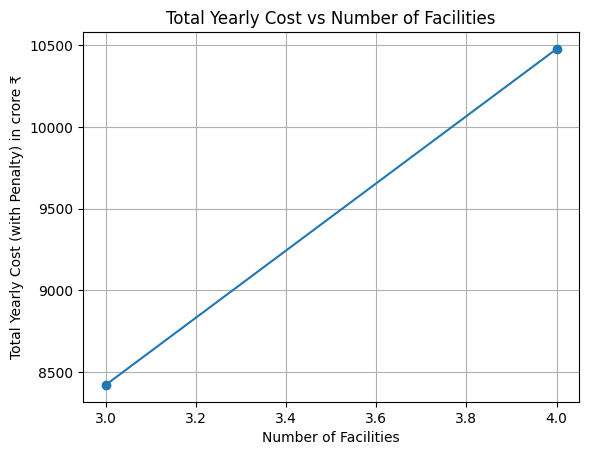

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import Model, GRB
import math

def calculate_min_facilities(demand, production_capacity_per_facility):
    # Calculate the minimum number of facilities required to meet the demand
    required_facilities = demand / production_capacity_per_facility
    # Round up since we can't have fractional facilities
    return int(np.ceil(required_facilities))

def display_results(facilities, model, num_storage_units, num_transport_units, extra_capacity_per_facility, total_yearly_cost_with_penalty, total_GWP, total_risk):
    # Display the results for a given number of facilities
    print(f"\nFacilities: {facilities}")
    print(f"Optimal Number of Storage Units: {num_storage_units.x}")
    print(f"Optimal Number of Transport Units: {num_transport_units.x}")
    print(f"Extra Capacity per Facility (tonnes/day): {extra_capacity_per_facility.x}")
    print(f"Total Yearly Cost (in crore ₹): {total_yearly_cost_with_penalty.getValue()}")
    print(f"Total GWP (in 10^3 t CO2-equiv per day): {total_GWP.getValue()}")
    print(f"Total Risk (unitless): {total_risk.getValue()}")
    
    return total_yearly_cost_with_penalty.getValue()

def plot_cost_comparison(all_results):
    # Plot total yearly cost (with penalty) vs number of facilities
    facilities_list, cost_list = zip(*all_results)
    
    plt.plot(facilities_list, cost_list, marker='o')
    plt.xlabel('Number of Facilities')
    plt.ylabel('Total Yearly Cost (with Penalty) in crore ₹')
    plt.title('Total Yearly Cost vs Number of Facilities')
    plt.grid(True)
    plt.show()

def run_optimization():
    # Get user input for demand and facility parameters
    demand = int(input("Enter the demand (tonnes per day): "))
    min_facilities = int(input("Enter the minimum number of facilities: "))
    max_facilities = int(input("Enter the maximum number of facilities: "))
    production_capacity_per_facility = float(input("Enter the production capacity per facility (tonnes per day): "))

    # Facility costs (in crore ₹)
    capital_cost_production = 354.825  # per facility (converted from $47.31M to crore ₹)
    capital_cost_storage = 0.6        # per tonne (converted from $0.08M to crore ₹)
    capital_cost_transport = 0.0075   # per tonne-km (converted from $0.001M to crore ₹)
    facility_setup_cost = 2000        # cost to set up one facility in crore ₹

    # Operating costs (in crore ₹ per day)
    operating_cost_production = 0.1575  # converted from $0.021M to crore ₹
    operating_cost_storage = 0.00375   # converted from $0.0005M to crore ₹
    operating_cost_transport = 0.00075 # converted from $0.0001M to crore ₹

    # GWP (in 10^3 t CO2-equiv per day)
    GWP_production = 135.27
    GWP_storage = 70.33
    GWP_transport = 0.002

    # Risk (unitless scale)
    risk_production = 580
    risk_storage = 5155
    risk_transport = 40

    # Create the model
    model = Model('Hydrogen Supply Chain Optimization')

    # Define the facility production capacity
    facility_production_capacity = production_capacity_per_facility  # This should be the production capacity per facility (tonnes per day)

    # Decision variables
    num_facilities = model.addVar(vtype=GRB.INTEGER, name="num_facilities", lb=min_facilities, ub=max_facilities)
    num_storage_units = model.addVar(vtype=GRB.CONTINUOUS, name="num_storage_units")
    num_transport_units = model.addVar(vtype=GRB.CONTINUOUS, name="num_transport_units")
    extra_capacity_per_facility = model.addVar(vtype=GRB.CONTINUOUS, name="extra_capacity_per_facility", lb=0)

    # Cost calculation variables
    total_capital_cost = model.addVar(vtype=GRB.CONTINUOUS, name="total_capital_cost")
    total_operating_cost = model.addVar(vtype=GRB.CONTINUOUS, name="total_operating_cost")

    # Recovery time (in days)
    recovery_time = 365  # e.g., recovery in 365 days, adjust as needed

    # Cost calculations for facilities and extra capacity
    capital_cost = capital_cost_production * num_facilities + capital_cost_storage * num_storage_units + capital_cost_transport * num_transport_units
    operating_cost = operating_cost_production * num_facilities + operating_cost_storage * num_storage_units + operating_cost_transport * num_transport_units

    # Adding cost for extra production capacity if needed
    extra_capacity_cost = extra_capacity_per_facility * capital_cost_production

    # Recovery cost per day (considering the time for recovery)
    recovery_cost_per_day = facility_setup_cost * num_facilities / recovery_time

    # Total cost per day
    total_daily_cost = operating_cost + recovery_cost_per_day + extra_capacity_cost

    # Total yearly cost (for 365 days)
    total_yearly_cost = total_daily_cost * 365

    # GWP and Risk calculations
    total_GWP = GWP_production * num_facilities + GWP_storage * num_storage_units + GWP_transport * num_transport_units
    total_risk = risk_production * num_facilities + risk_storage * num_storage_units + risk_transport * num_transport_units

    # Constraints
    model.addConstr(num_storage_units >= demand, "Storage demand constraint")
    model.addConstr(num_transport_units >= demand, "Transport demand constraint")

    # Production capacity constraint: each facility should produce within its capacity
    model.addConstr(facility_production_capacity * num_facilities + extra_capacity_per_facility >= demand, "Production capacity constraint")

    # Variable to track unmet demand
    unmet_demand = model.addVar(vtype=GRB.CONTINUOUS, name="unmet_demand", lb=0)

    # Compute the unmet demand using the formula: unmet demand = max(0, demand - available capacity)
    model.addConstr(unmet_demand >= demand - (facility_production_capacity * num_facilities + extra_capacity_per_facility), "Unmet demand constraint")

    # Penalty cost for unmet demand
    penalty_cost_per_tonne = 0.1  # Assume a penalty cost per tonne of unmet demand (in crore ₹)
    penalty_cost = penalty_cost_per_tonne * unmet_demand

    # Add penalty cost to the total cost
    total_yearly_cost_with_penalty = total_yearly_cost + penalty_cost

    # Objective function (minimize yearly cost including penalty)
    model.setObjective(total_yearly_cost_with_penalty, GRB.MINIMIZE)

    # Calculate the minimum number of facilities required
    required_facilities = calculate_min_facilities(demand, production_capacity_per_facility)

    # Variables to track the optimal solution
    optimal_facilities = None
    optimal_cost = float('inf')

    # Store all results to display later
    all_results = []

    # Loop over the possible number of facilities and compare costs
    for facilities in range(min_facilities, max_facilities + 1):
        # Set the number of facilities for the current iteration
        num_facilities.setAttr("lb", max(facilities, required_facilities))  # Ensure the facilities are >= required_facilities
        num_facilities.setAttr("ub", facilities)

        model.optimize()

        if model.status == GRB.OPTIMAL:
            current_cost = display_results(facilities, model, num_storage_units, num_transport_units, extra_capacity_per_facility, total_yearly_cost_with_penalty, total_GWP, total_risk)
            
            all_results.append((facilities, current_cost))
            # Update the optimal configuration if the current configuration is better
            if current_cost < optimal_cost:
                optimal_cost = current_cost
                optimal_facilities = facilities

    # Display all results
    print("\nComparison of all configurations:")
    for facilities, cost in all_results:
        print(f"{facilities} Facilities - Total Yearly Cost (with Penalty): {cost}")

    # Display the optimal number of facilities
    print(f"\nOptimal Number of Facilities: {optimal_facilities}")
    # Show the optimal results for the optimal facility count
    display_results(optimal_facilities, model, num_storage_units, num_transport_units, extra_capacity_per_facility, total_yearly_cost_with_penalty, total_GWP, total_risk)
    
    # Plot the comparison of total yearly cost vs number of facilities
    plot_cost_comparison(all_results)

if __name__ == "__main__":
    run_optimization()


Enter the demand for green hydrogen (in tonnes/day):  1369
Enter the minimum number of facilities:  1
Enter the maximum number of facilities:  4
Enter the production capacity of each facility (in tonnes/day):  500
Enter the time period (in years) for evaluating profitability:  8


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G7 CPU @ 1.20GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4 rows, 7 columns and 7 nonzeros
Model fingerprint: 0x584deadf
Variable types: 6 continuous, 1 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 5e+02]
  Objective range  [1e-01, 1e+05]
  Bounds range     [1e+00, 3e+00]
  RHS range        [1e+03, 1e+03]
Presolve time: 0.00s

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i5-1035G7 CPU @ 1.20GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, u

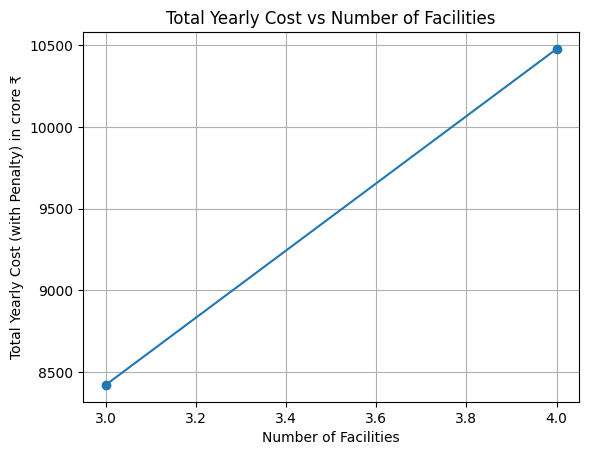

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import Model, GRB
import math

def calculate_min_facilities(demand, production_capacity_per_facility):
    # Calculate the minimum number of facilities required to meet the demand
    required_facilities = demand / production_capacity_per_facility
    # Round up since we can't have fractional facilities
    return int(np.ceil(required_facilities))

def display_results(facilities, model, num_storage_units, num_transport_units, extra_capacity_per_facility, total_yearly_cost_with_penalty, total_GWP, total_risk):
    # Display the results for a given number of facilities
    print(f"\nFacilities: {facilities}")
    print(f"Optimal Number of Storage Units: {num_storage_units.x}")
    print(f"Optimal Number of Transport Units: {num_transport_units.x}")
    print(f"Extra Capacity per Facility (tonnes/day): {extra_capacity_per_facility.x}")
    print(f"Total Yearly Cost (in crore ₹): {total_yearly_cost_with_penalty.getValue()}")
    print(f"Total GWP (in 10^3 t CO2-equiv per day): {total_GWP.getValue()}")
    print(f"Total Risk (unitless): {total_risk.getValue()}")
    
    return total_yearly_cost_with_penalty.getValue()

def plot_cost_comparison(all_results):
    # Plot total yearly cost (with penalty) vs number of facilities
    facilities_list, cost_list = zip(*all_results)
    
    plt.plot(facilities_list, cost_list, marker='o')
    plt.xlabel('Number of Facilities')
    plt.ylabel('Total Yearly Cost (with Penalty) in crore ₹')
    plt.title('Total Yearly Cost vs Number of Facilities')
    plt.grid(True)
    plt.show()

def run_optimization():
    # Get user input for demand and facility parameters
    demand = int(input("Enter the demand for green hydrogen (in tonnes/day): "))
    min_facilities = int(input("Enter the minimum number of facilities: "))
    max_facilities = int(input("Enter the maximum number of facilities: "))
    production_capacity_per_facility = float(input("Enter the production capacity of each facility (in tonnes/day): "))
    years = int(input("Enter the time period (in years) for evaluating profitability: "))

    # Facility costs (in crore ₹)
    capital_cost_production = 354.825  # per facility (converted from $47.31M to crore ₹)
    capital_cost_storage = 0.6        # per tonne (converted from $0.08M to crore ₹)
    capital_cost_transport = 0.0075   # per tonne-km (converted from $0.001M to crore ₹)
    facility_setup_cost = 2000        # cost to set up one facility in crore ₹

    # Operating costs (in crore ₹ per day)
    operating_cost_production = 0.1575  # converted from $0.021M to crore ₹
    operating_cost_storage = 0.00375   # converted from $0.0005M to crore ₹
    operating_cost_transport = 0.00075 # converted from $0.0001M to crore ₹

    # GWP (in 10^3 t CO2-equiv per day)
    GWP_production = 135.27
    GWP_storage = 70.33
    GWP_transport = 0.002

    # Risk (unitless scale)
    risk_production = 580
    risk_storage = 5155
    risk_transport = 40

    # Revenue calculations (for profitability evaluation)
    revenue_per_tonne = 5000  # assumed revenue per tonne of green hydrogen (in crore ₹)

    # Create the model
    model = Model('Hydrogen Supply Chain Optimization')

    # Define the facility production capacity
    facility_production_capacity = production_capacity_per_facility  # This should be the production capacity per facility (tonnes per day)

    # Decision variables
    num_facilities = model.addVar(vtype=GRB.INTEGER, name="num_facilities", lb=min_facilities, ub=max_facilities)
    num_storage_units = model.addVar(vtype=GRB.CONTINUOUS, name="num_storage_units")
    num_transport_units = model.addVar(vtype=GRB.CONTINUOUS, name="num_transport_units")
    extra_capacity_per_facility = model.addVar(vtype=GRB.CONTINUOUS, name="extra_capacity_per_facility", lb=0)

    # Cost calculation variables
    total_capital_cost = model.addVar(vtype=GRB.CONTINUOUS, name="total_capital_cost")
    total_operating_cost = model.addVar(vtype=GRB.CONTINUOUS, name="total_operating_cost")

    # Recovery time (in days)
    recovery_time = 365  # e.g., recovery in 365 days, adjust as needed

    # Cost calculations for facilities and extra capacity
    capital_cost = capital_cost_production * num_facilities + capital_cost_storage * num_storage_units + capital_cost_transport * num_transport_units
    operating_cost = operating_cost_production * num_facilities + operating_cost_storage * num_storage_units + operating_cost_transport * num_transport_units

    # Adding cost for extra production capacity if needed
    extra_capacity_cost = extra_capacity_per_facility * capital_cost_production

    # Recovery cost per day (considering the time for recovery)
    recovery_cost_per_day = facility_setup_cost * num_facilities / recovery_time

    # Total cost per day
    total_daily_cost = operating_cost + recovery_cost_per_day + extra_capacity_cost

    # Total yearly cost (for 365 days)
    total_yearly_cost = total_daily_cost * 365

    # GWP and Risk calculations
    total_GWP = GWP_production * num_facilities + GWP_storage * num_storage_units + GWP_transport * num_transport_units
    total_risk = risk_production * num_facilities + risk_storage * num_storage_units + risk_transport * num_transport_units

    # Constraints
    model.addConstr(num_storage_units >= demand, "Storage demand constraint")
    model.addConstr(num_transport_units >= demand, "Transport demand constraint")

    # Production capacity constraint: each facility should produce within its capacity
    model.addConstr(facility_production_capacity * num_facilities + extra_capacity_per_facility >= demand, "Production capacity constraint")

    # Variable to track unmet demand
    unmet_demand = model.addVar(vtype=GRB.CONTINUOUS, name="unmet_demand", lb=0)

    # Compute the unmet demand using the formula: unmet demand = max(0, demand - available capacity)
    model.addConstr(unmet_demand >= demand - (facility_production_capacity * num_facilities + extra_capacity_per_facility), "Unmet demand constraint")

    # Penalty cost for unmet demand
    penalty_cost_per_tonne = 0.1  # Assume a penalty cost per tonne of unmet demand (in crore ₹)
    penalty_cost = penalty_cost_per_tonne * unmet_demand

    # Add penalty cost to the total cost
    total_yearly_cost_with_penalty = total_yearly_cost + penalty_cost

    # Objective function (minimize yearly cost including penalty)
    model.setObjective(total_yearly_cost_with_penalty, GRB.MINIMIZE)

    # Calculate the minimum number of facilities required
    required_facilities = calculate_min_facilities(demand, production_capacity_per_facility)

    # Variables to track the optimal solution
    optimal_facilities = None
    optimal_cost = float('inf')

    # Store all results to display later
    all_results = []

    # Loop over the possible number of facilities and compare costs
    for facilities in range(min_facilities, max_facilities + 1):
        # Set the number of facilities for the current iteration
        num_facilities.setAttr("lb", max(facilities, required_facilities))  # Ensure the facilities are >= required_facilities
        num_facilities.setAttr("ub", facilities)

        model.optimize()

        if model.status == GRB.OPTIMAL:
            current_cost = display_results(facilities, model, num_storage_units, num_transport_units, extra_capacity_per_facility, total_yearly_cost_with_penalty, total_GWP, total_risk)

            # Calculate yearly revenue and profit over 10 years
            yearly_revenue = demand * revenue_per_tonne
            profit_over_10_years = (yearly_revenue - current_cost) * years

            all_results.append((facilities, current_cost, yearly_revenue, profit_over_10_years))

            # Update the optimal configuration if the current configuration is better
            if current_cost < optimal_cost:
                optimal_cost = current_cost
                optimal_facilities = facilities

    # Display optimal results
    print(f"\nOptimal Number of Facilities: {optimal_facilities}")
    optimal_cost = display_results(optimal_facilities, model, num_storage_units, num_transport_units, extra_capacity_per_facility, total_yearly_cost_with_penalty, total_GWP, total_risk)

    # Calculate and display the optimal profitability
    optimal_revenue = demand * revenue_per_tonne
    optimal_profit = (optimal_revenue - optimal_cost) * years
    print(f"Total Yearly Cost: {optimal_cost}")
    print(f"Total Yearly Revenue: {optimal_revenue}")
    print(f"Total Profit over {years} years: {optimal_profit}")

    # Display the comparison of all configurations with profits
    print("\nComparison of all configurations:")
    for facilities, cost, revenue, profit in all_results:
        print(f"{facilities} Facilities - Total Yearly Cost: {cost}, Total Yearly Revenue: {revenue}, Profit over {years} years: {profit}")

    # Plot the comparison of total yearly cost vs number of facilities
    plot_cost_comparison([(facilities, cost) for facilities, cost, _, _ in all_results])

if __name__ == "__main__":
    run_optimization()

